In [1]:
import numpy as np
import skimage.io
import base64
import rpyc
import time
import os
import matplotlib.pyplot as plt
import socket

In [2]:
# Test image location
barnyard_test = '/media/srirampendyala/Data2/barnyard_data/07-26-2018_U2OS_pNH039_pSP006_Imaging/07-26-2018_U2OS_pNH039_pSP006_Imaging_A01_s107_w1.TIF'

In [3]:
# Import test image
np_pixels = skimage.io.imread(barnyard_test)
np_pixels = (np_pixels//256).astype('uint8')
height, width = np_pixels.shape

In [4]:
def normalize_image(img):
    
    if len(img.shape) == 2:
        
        percentile = 99.9
        high = np.percentile(img, percentile)
        low = np.percentile(img, 100-percentile)

        img = np.minimum(high, img)
        img = np.maximum(low, img)

        img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
        img = skimage.img_as_ubyte(img)

        # make a RGB-channel color image
        img_norm = np.stack([img, img, img], axis=-1)
        
    else:
        img_norm = np.zeros(img.shape, dtype='uint8')
        for ix in range(img.shape[2]):
            
            img_channel =  img[:,:,ix]
            percentile = 99.9
            high = np.percentile(img_channel, percentile)
            low = np.percentile(img_channel, 100-percentile)

            img_channel = np.minimum(high, img_channel)
            img_channel = np.maximum(low, img_channel)

            img_channel = (img_channel - low) / (high - low) # gives float64, thus cast to 8 bit later
            img_norm[:,:,ix] = skimage.img_as_ubyte(img_channel)
            
    return img_norm

In [5]:
def get_outputmask(image_name, output_mask):
    #....
    print("call back in client", image_name)

In [8]:
# Send to GPU server
start = time.time()
while True:
    try:
        conn = rpyc.connect("128.208.8.66", 18871)
        break
    except socket.timeout:
        print('Caught a timeout! Reconnecting...')
        time.sleep(2)
bgsrv = rpyc.BgServingThread(conn)
mon = conn.root.ImageAnalysis(get_outputmask)
b64_output_mask = mon.run_pipeline_on_image('test_img', base64.b64encode(np_pixels))
np_output_mask = np.frombuffer(base64.decodebytes(b64_output_mask), np.uint8).reshape((height,width))
bgsrv.stop()
conn.close()
end = time.time()
print('Wall time: ' + str((end-start)*1000) + 'ms')

Wall time: 4507.813215255737ms


/home/srirampendyala/anaconda3/envs/deep-learning/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/srirampendyala/anaconda3/envs/deep-learning/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/srirampendyala/anaconda3/envs/deep-learning/lib/python3.6/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


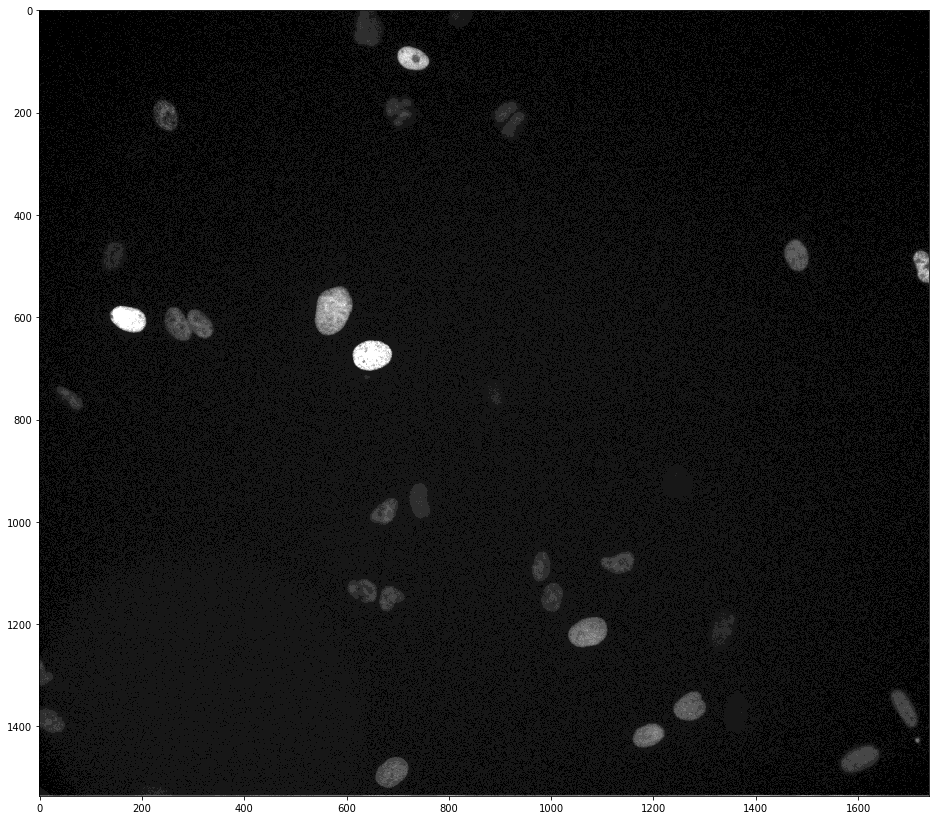

/home/srirampendyala/anaconda3/envs/deep-learning/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


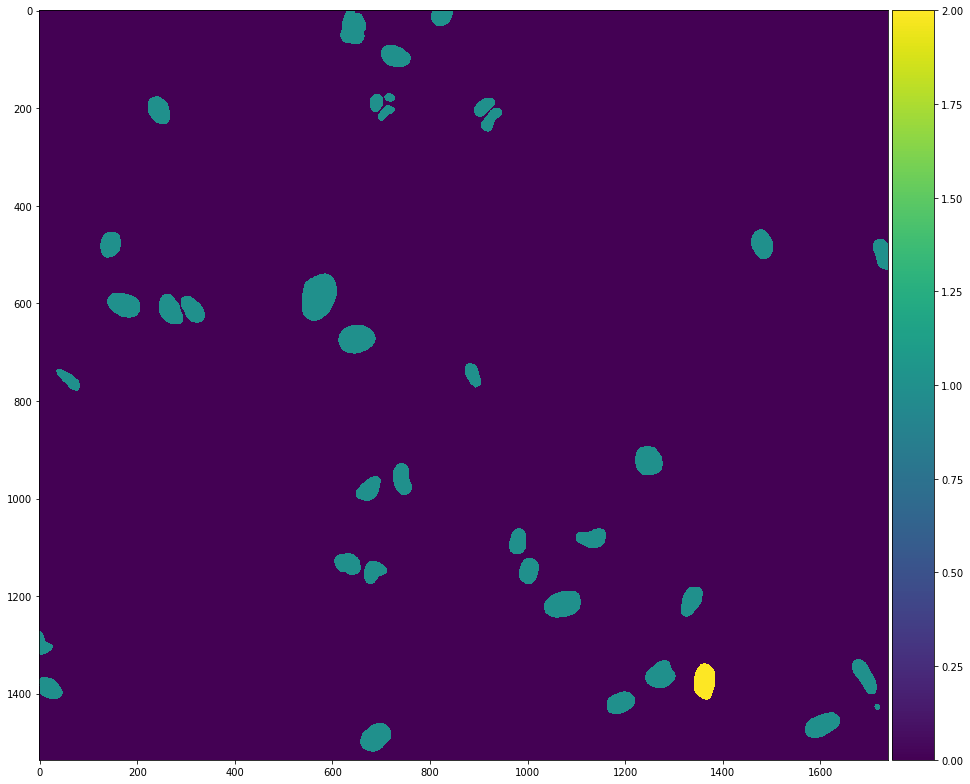

In [9]:
#Visualize both image and mask
plt.figure(num=None, figsize=(13.5,11.5))
skimage.io.imshow(normalize_image(np_pixels))
plt.show()

plt.figure(num=None, figsize=(13.5,11.5))
skimage.io.imshow(np_output_mask)
plt.show()